<a href="https://colab.research.google.com/github/raulbenitez/DL_AMRITA/blob/main/deep_LFW_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Introduction to Deep Learning
AMRITA 2022 Tutorial

---

Raul Benitez, PhD

Universitat Politècnica de Catalunya

contact: raul.benitez@upc.edu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
folder_data = '/content/drive/MyDrive/DL_AMRITA/LFW'
load_data = 'True' #Set to 'True' to load data and avoid time consuming executions

# Part 1: LFW data exploration

## Load LFW data

In [3]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.datasets import fetch_lfw_people
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

## load LFW images in RGB:
lfw_people = fetch_lfw_people(min_faces_per_person=200,funneled=True,resize=1,color=True)

## Get images (RGB or Grayscale):
if lfw_people.images.ndim == 4:
  n_samples, h, w, ch = lfw_people.images.shape
  print('{} RGB images of size {} x {}'.format(n_samples,h,w))

else:
  n_samples, h, w = lfw_people.images.shape
  ch = 1
  print('{} grayscale images of size {} x {}'.format(n_samples,h,w))



## Get data matrix (OBSERVATIONS x PIXELS*CHANNELS):
XRGB = lfw_people.data
n_features = XRGB.shape[1]

## Class labels vector:
yRGB = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print('Number of faces to be recognized {}'.format(n_classes))

## Split training and test subsets:
x_train, x_test, y_train, y_test = train_test_split(
    XRGB, yRGB, test_size=0.30, random_state=42)

## Reshape as tensor arrays (samples,height, width, channels) and convert to float 
x_train1 = x_train.reshape(x_train.shape[0],h,w,ch).astype('float32')
x_test1 = x_test.reshape(x_test.shape[0],h,w,ch).astype('float32')

766 RGB images of size 125 x 94
Number of faces to be recognized 2


## Visualize image dataset 

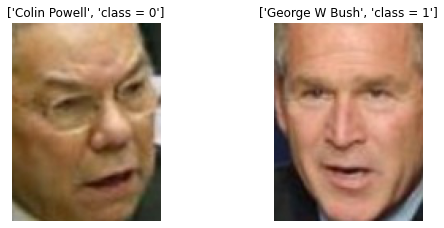

In [4]:
import skimage as sk # load skimage libraries
from skimage import io
import matplotlib.pylab as plt

label_names = target_names

fig = plt.figure(figsize=(18, 8))

for kclass in range(0,n_classes):
    ind = np.argwhere(y_train==kclass)
    ax = fig.add_subplot(2, 4, kclass+1)
    ax.imshow(np.uint8(x_train1[ind[0][0]].squeeze()),cmap=plt.cm.gray)
    ax.set_title([label_names[kclass], 'class = {}'.format(kclass)])
    ax.axis('off')

## Low-dimension projections of the MNIST test data subset

## 2D PCA projection

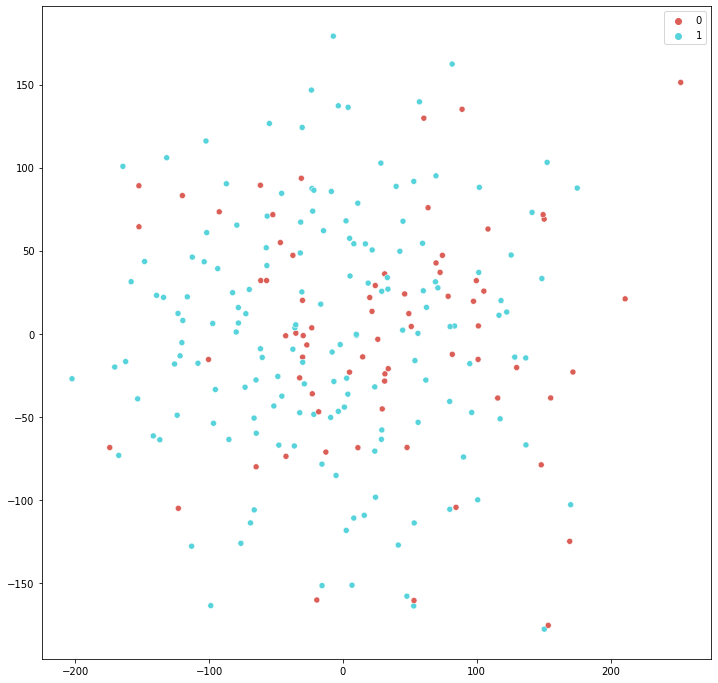

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Reshape datasets as NOBSERVATIONS x NPIXELS (Flatten):
train = x_train.reshape(x_train1.shape[0],x_train1.shape[1]*x_train1.shape[2]*x_train1.shape[3])
test = x_test.reshape(x_test1.shape[0],x_test1.shape[1]*x_test1.shape[2]*x_test1.shape[3])

# Scale (Standardization)
train = StandardScaler().fit_transform(train)
test = StandardScaler().fit_transform(test)

# PROJECT TO A 2D PCA SPACE:
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(test)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = pca_proj[:,0], y = pca_proj[:,1], hue = y_test, palette = sns.hls_palette(n_classes), legend = 'full')
plt.show()

In [6]:
print('The size of flattened training data is {}'.format(train.shape))
print('The size of flattened test data is {}'.format(test.shape))
print('The size of the 2D PCA projection of the test data is {}'.format(pca_proj.shape))

The size of flattened training data is (536, 35250)
The size of flattened test data is (230, 35250)
The size of the 2D PCA projection of the test data is (230, 2)


No surprise that all classes are entangled in the 2d PCA projection since the variance explained by a 2D PCA projection is only a fraction of the total variability:

In [7]:
pca.explained_variance_ratio_.cumsum()

array([0.21084528, 0.35245425], dtype=float32)

## T-SNE projection 

Visualizing high-dimensional data by projecting it into a low-dimensional space

https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf



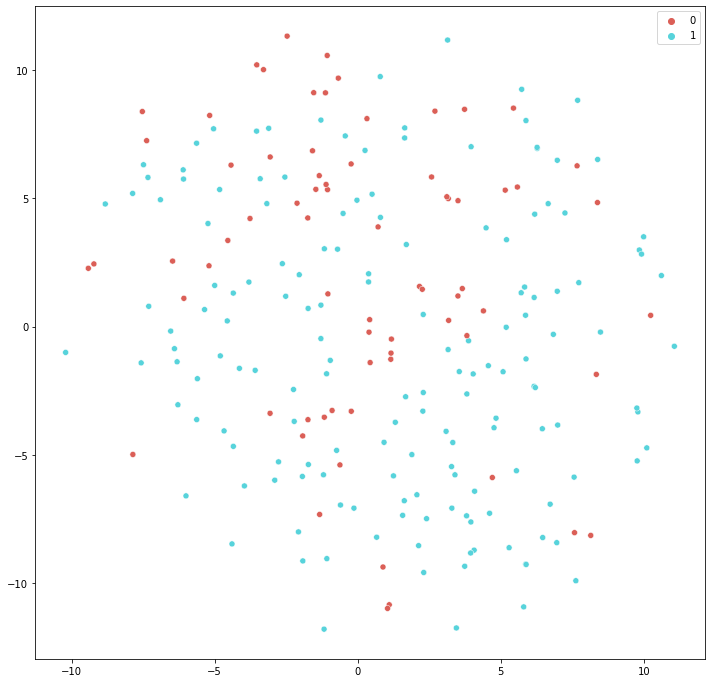

In [8]:
from sklearn.manifold import TSNE

if load_data == 'False':
  tsne = TSNE(n_components = 2, random_state=0)
  tsne_res = tsne.fit_transform(test)
else:
  data = np.load(folder_data+'/tsne.npz')
  tsne_res = data['arr_1']

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_test, palette = sns.hls_palette(n_classes), legend = 'full');

## PCA + t-SNE

Let's first project into a PCA space explaining 95% of the variability and then visualize the PCA projection using a 2D t-SNE manifold

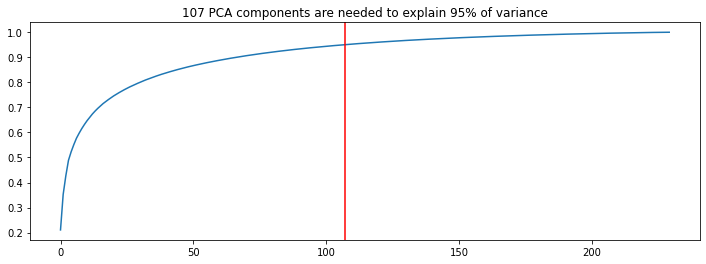

In [9]:
pca_full = PCA(n_components=test.shape[0])
pca_full.fit(test)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(12,4))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

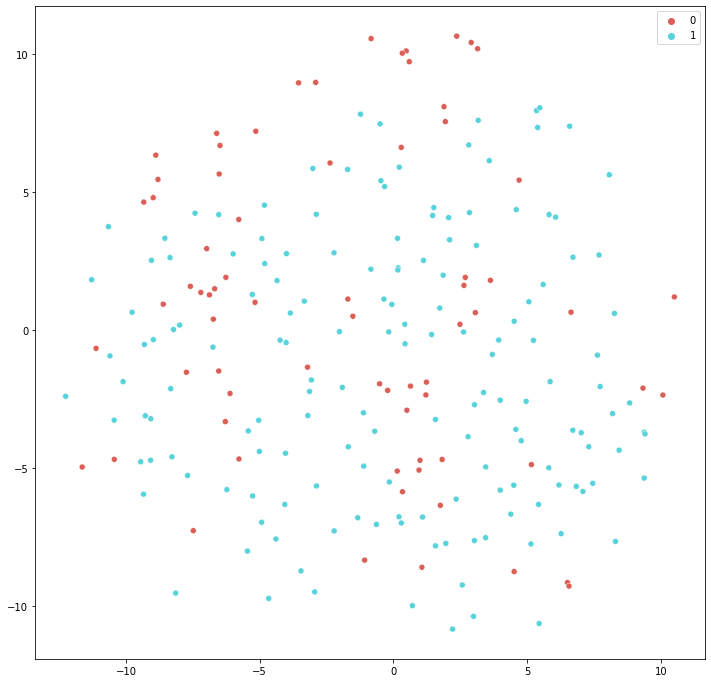

In [10]:
pca95 = PCA(n_components=Ncomponents_95)
pca95_proj = pca95.fit_transform(test)

if load_data == 'False':
  tsne = TSNE(n_components = 2, random_state=0)
  tsne_pca = tsne.fit_transform(pca95_proj)
  np.savez(folder_data+'/tsne.npz', tsne_pca,tsne_res)
else:
  data = np.load(folder_data+'/tsne.npz')
  tsne_pca = data['arr_0']

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_pca[:,0], y = tsne_pca[:,1], hue = y_test, palette = sns.hls_palette(n_classes), legend = 'full');

PCA as feature extraction works pretty well (eigenfaces)

## Clustering - unsupervised approach
In this section we apply an unsupervised clustering approach to identfy each cluster in the feature space. In particular, we apply a Gaussian Mixture Model with model selection using the Bayesian Information Criterion parsimony index.


[2867.319888595365]
[2867.319888595365, 2867.7393109351747]
[2867.319888595365, 2867.7393109351747, 2878.294154706312]
[2867.319888595365, 2867.7393109351747, 2878.294154706312, 2905.4547518463655]
[2867.319888595365, 2867.7393109351747, 2878.294154706312, 2905.4547518463655, 2925.650153629083]
[2867.319888595365, 2867.7393109351747, 2878.294154706312, 2905.4547518463655, 2925.650153629083, 2952.376026386604]
[2867.319888595365, 2867.7393109351747, 2878.294154706312, 2905.4547518463655, 2925.650153629083, 2952.376026386604, 2987.2447143492764]
[2867.319888595365, 2867.7393109351747, 2878.294154706312, 2905.4547518463655, 2925.650153629083, 2952.376026386604, 2987.2447143492764, 3020.7296079589605]
[2867.319888595365, 2867.7393109351747, 2878.294154706312, 2905.4547518463655, 2925.650153629083, 2952.376026386604, 2987.2447143492764, 3020.7296079589605, 3039.7339452029582]
[2867.319888595365, 2867.7393109351747, 2878.294154706312, 2905.4547518463655, 2925.650153629083, 2952.376026386604,

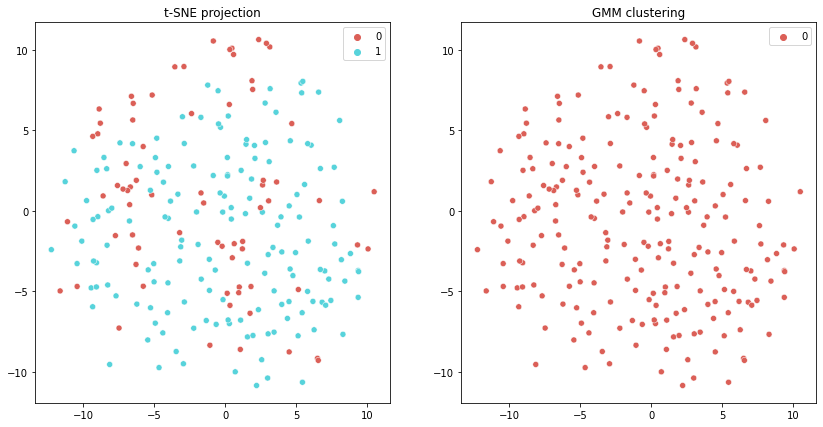

In [11]:
from sklearn import mixture

X = tsne_pca[:,0:2]

NMAX = 12
bic = []
for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(X)
    bic.append(gmm.bic(X))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))
gmm = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(X)
y_pred_gmm = gmm.fit_predict(X)


plt.figure(figsize=(14,7))

ax0 = plt.subplot(1,2,1)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_test, palette = sns.hls_palette(n_classes), legend = 'full');
plt.title("t-SNE projection")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y_pred_gmm, palette = sns.hls_palette(idx_winner+1));
plt.title("GMM clustering")
plt.show()

Some digits can be easily identified as an isolated cluster, others are identified as two subgroups. We also observe that two different digits are grouped together as a single cluster. 

## UMAP Projection


UMAP is a flexible non-linear dimension reduction algorithm that learns the manifold structure of your data and find a low dimensional embedding that preserves its topological structure.

https://arxiv.org/abs/1802.03426

https://umap-learn.readthedocs.io/en/latest/

First, install UMAP library in google colab platform

In [12]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 33.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=38351a8f18d70e174df67185e79df809c5e2ce06a650407cfeae83e57ad16623
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=4bf6bbc0366cabc5cc199c36df461a62c36aa37f35356468c7c293e0499c262d
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [13]:
import umap
import pickle

if load_data == 'False':
  mapper = umap.UMAP().fit(test) # create the UMAP mapper
  embedding = mapper.transform(test) # project data 
  np.savez(folder_data+'/umap.npz', embedding)
  pickle.dump(mapper, open(folder_data+'/umap_mapper.sav', 'wb'))
else: 
  data = np.load(folder_data+'/umap.npz')
  embedding = data['arr_0']
  mapper = pickle.load(open(folder_data+'/umap_mapper.sav', 'rb'))

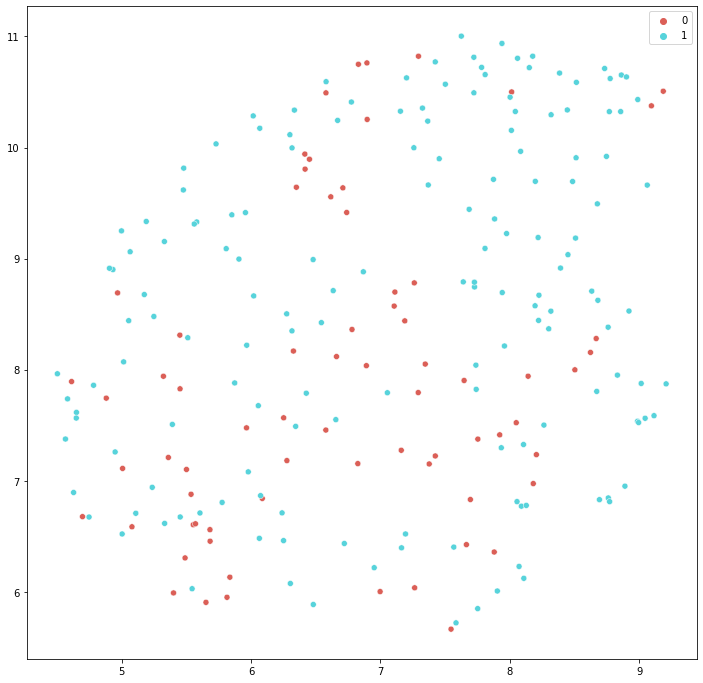

In [14]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue = y_test, palette = sns.hls_palette(n_classes), legend = 'full');

Visualize the projected data using the inverse UMAP projection on a grid

In [17]:
corners = np.array([
    [5, 5],  # bottom left corner
    [10, 5],  # bottom right
    [5, 11],  # top left
    [10, 11],  # top right
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

In [18]:
inv_transformed_points = mapper.inverse_transform(test_pts)

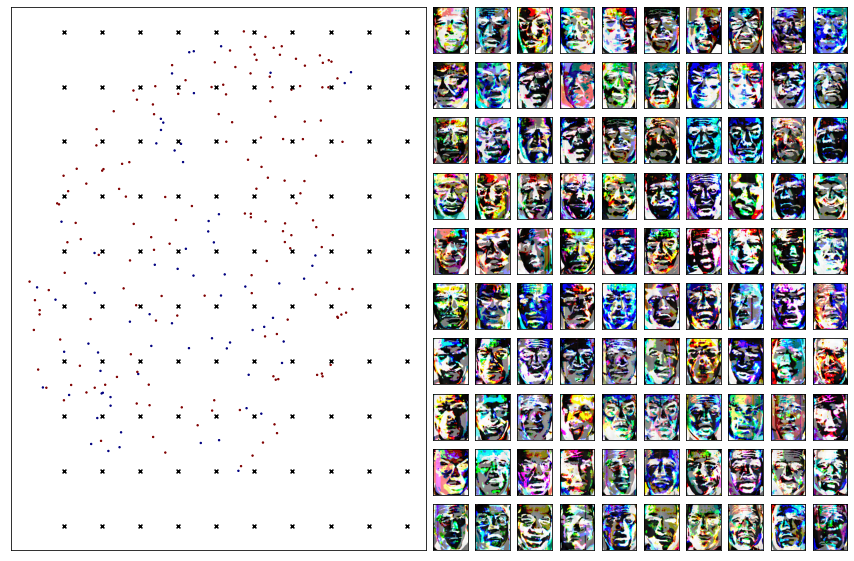

In [19]:
from matplotlib.gridspec import GridSpec

def norm_im(X):
  X_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  return X_scaled

# Set up the grid
fig = plt.figure(figsize=(15,10))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1],
                   c=y_test.astype(np.int32), cmap='jet', s=2)
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], marker='x', c='k', s=15)

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(norm_im(inv_transformed_points[i*10 + j].reshape(h,w,ch)))
        digit_axes[i, j].set(xticks=[], yticks=[])

# Part 2: The Traditional Machine Learning approach



## Fit a KNN classifier using raw data

               precision    recall  f1-score   support

 Colin Powell       0.66      0.89      0.76        71
George W Bush       0.94      0.80      0.86       159

     accuracy                           0.83       230
    macro avg       0.80      0.84      0.81       230
 weighted avg       0.86      0.83      0.83       230



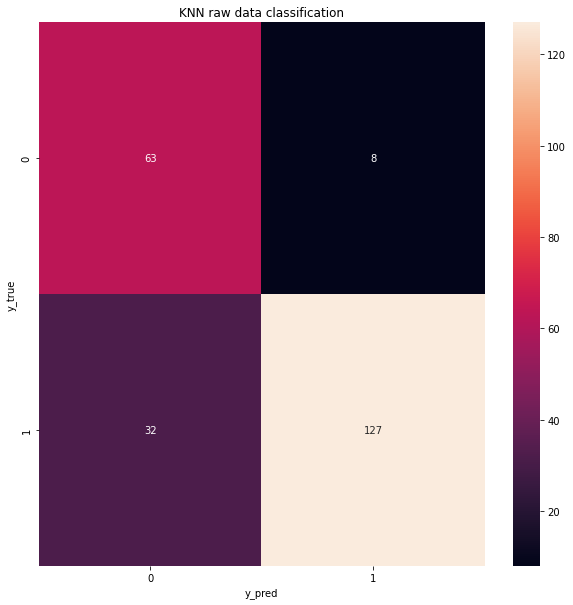

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

if load_data == 'False':
  knn_raw = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_raw.fit(train,y_train) # fit the model using training data
  y_test_pred_raw = knn_raw.predict(test) # model prediction of test data

  pickle.dump(knn_raw, open(folder_data+'/knn_raw_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_raw.npz', y_test_pred_raw)

else:
  knn_raw = pickle.load(open(folder_data+'/knn_raw_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_raw.npz')
  y_test_pred_raw = data['arr_0']

cm_raw = confusion_matrix(y_test, y_test_pred_raw)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_raw,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN raw data classification')

label_names = target_names
print(classification_report(y_test, y_test_pred_raw, target_names=label_names))

## Fit a kNN classifier using PCA features: eigenfaces

Use PCA to extract features from the images and classify them using a KNN  algorithm. Keep as many PCA components as needed to explain 95% of the variance in the training set.

In [22]:
# GET PCA FEATURES PROJECTING TO THE PCA SPACE:
pca_train = pca95.fit_transform(train)
pca_test = pca95.fit_transform(test)

print('Number of PCA components needed to explain 95% of variability is {}'.format(Ncomponents_95))
print('The PCA training set has dimensions {} {}'.format(*pca_train.shape))
print('The PCA test set has dimensions {} {}'.format(*pca_test.shape))

Number of PCA components needed to explain 95% of variability is 107
The PCA training set has dimensions 536 107
The PCA test set has dimensions 230 107


In [23]:
from sklearn.neighbors import KNeighborsClassifier

if load_data == 'False':
  knn = KNeighborsClassifier(n_neighbors=2) # load the model
  knn.fit(pca_train,y_train) # fit the model using training data
  y_test_pred = knn.predict(pca_test) # model prediction of test data

  pickle.dump(knn, open(folder_data+'/knn_pca_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred.npz', y_test_pred)

else:
  knn = pickle.load(open(folder_data+'/knn_pca_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred.npz')
  y_test_pred = data['arr_0']


Text(0.5, 1.0, 'KNN pca features classification')

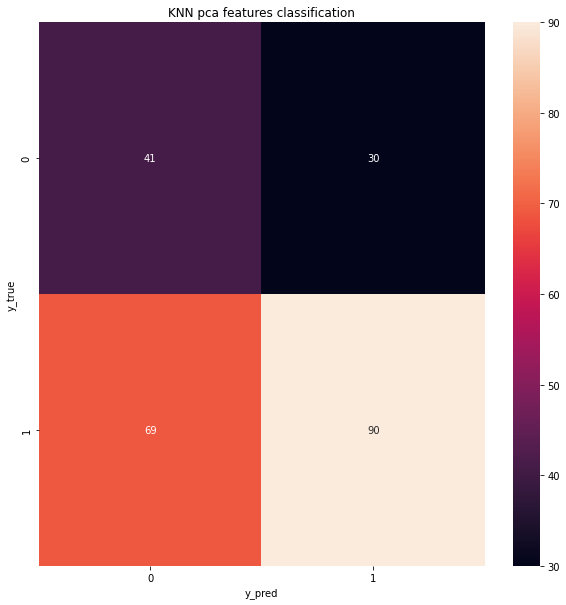

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN pca features classification')

In [25]:
print(classification_report(y_test, y_test_pred, target_names=label_names))

               precision    recall  f1-score   support

 Colin Powell       0.37      0.58      0.45        71
George W Bush       0.75      0.57      0.65       159

     accuracy                           0.57       230
    macro avg       0.56      0.57      0.55       230
 weighted avg       0.63      0.57      0.59       230



Traditional features do not always represent the full complexity of the classification problem

# Part 3: The DL approach

## Classification using pre-trained Deep Features: Transfer Learning

Use a pre-trained CNN architecture to extract deep features

### Pre-processing data 

Some pre-processing is needed in order to adjust input data to the CNN architecture

Instantiate the VGG16 model pre-trained with imagenet database. We load only the layers corresponding to the feature extraction and skip the last fully connected layers for classification (include_top=False). 


In [26]:
base_model1 = VGG16(weights='imagenet', include_top=False,input_shape=(h,w,ch))
model = Model(inputs=base_model1.input, outputs=base_model1.outputs)

58900480/58889256 [==============================] - 2s 0us/step


### Extract deep features

In [27]:
# Extracting features
if load_data == 'False':
  train_deep_features = model.predict(x_train1)
  test_deep_features = model.predict(x_test1)
  np.savez(folder_data+'/deep_feat.npz', train_deep_features, train_X,test_deep_features, test_X)
else: 
  data = np.load(folder_data+'/deep_feat.npz')
  train_deep_features = data['arr_0']
  train_X = data['arr_1']
  test_deep_features = data['arr_2']
  test_X = data['arr_3']

train_deep_features.shape,test_deep_features.shape

((536, 3, 2, 512), (230, 3, 2, 512))

Reshape extracted deep features 

In [28]:
test_deep_features1 = test_deep_features.reshape(test_deep_features.shape[0],test_deep_features.shape[1]*test_deep_features.shape[2]*test_deep_features.shape[3])
train_deep_features1 = train_deep_features.reshape(train_deep_features.shape[0],train_deep_features.shape[1]*train_deep_features.shape[2]*test_deep_features.shape[3])

### visualize deep features using UMAP

In [29]:
if load_data == 'False':
  umap_deep = umap.UMAP(n_neighbors=15).fit_transform(test_deep_features1)
  np.savez(folder_data+'/umap_deep.npz', umap_deep)
else: 
  data = np.load(folder_data+'/umap_deep.npz')
  umap_deep = data['arr_0']

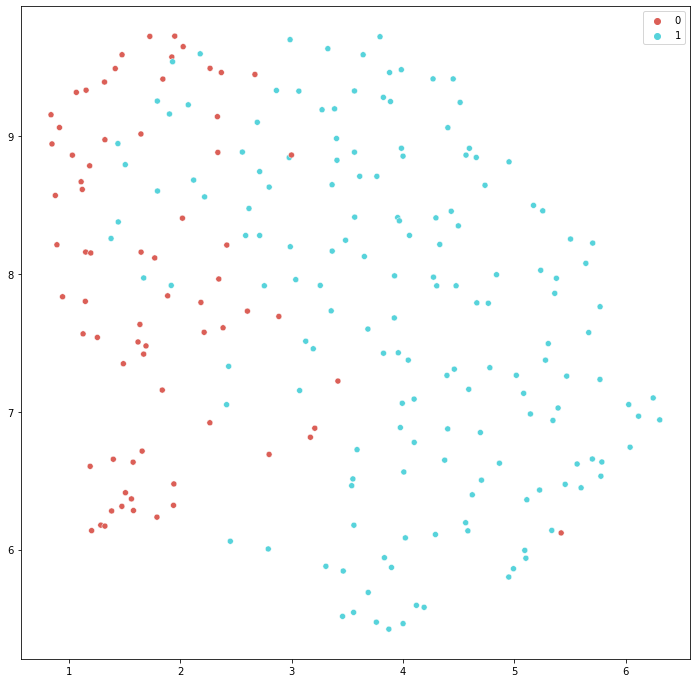

In [30]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_deep[:,0], y = umap_deep[:,1], hue = y_test, palette = sns.hls_palette(n_classes), legend = 'full');

### Classify with pre-trained, transfer-learned deep features

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

if load_data == 'False':
  knn_DL_TL = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_DL_TL.fit(train_deep_features1.squeeze(),y_train) # fit the model using training data
  y_test_pred_DL_TL = knn_DL_TL.predict(test_deep_features1.squeeze()) # model prediction of test data

  pickle.dump(knn_DL_TL, open(folder_data+'/knn_DL_TL.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_DL_TL.npz', y_test_pred)

else:
  knn_DL_TL = pickle.load(open(folder_data+'/knn_DL_TL.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_DL_TL.npz')
  y_test_pred_DL_TL = data['arr_0']

print(classification_report(y_test, y_test_pred_DL_TL, target_names=label_names))

               precision    recall  f1-score   support

 Colin Powell       0.37      0.58      0.45        71
George W Bush       0.75      0.57      0.65       159

     accuracy                           0.57       230
    macro avg       0.56      0.57      0.55       230
 weighted avg       0.63      0.57      0.59       230



We see that the overall accuracy of the classifier improves when using deep features instead PCA features

## The fully trained DL model

Both feature extraction and classification are performed using a simple custom-made CNN architecture trained with the MNIST training subset. 
MNIST classification using a simple CNN architecture 

From: https://keras.io/examples/vision/mnist_convnet/


### Build and train

In [32]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
input_shape = (h, w, 3)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, n_classes)
y_test_cat = keras.utils.to_categorical(y_test, n_classes)

In [33]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 92, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 44, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 22, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 40832)             0         
                                                                 
 dropout (Dropout)           (None, 40832)             0

In [34]:
batch_size = 128
epochs = 20
if load_data == 'False':
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(x_train1, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)
  model.save(folder_data + '/model_saved') # save trained model
else: 
  model = keras.models.load_model(folder_data + '/model_saved')

### Evaluate 

In [35]:
score = model.evaluate(x_test1, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(x_test1),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.22309699654579163
Test accuracy: 0.939130425453186
               precision    recall  f1-score   support

 Colin Powell       0.97      0.83      0.89        71
George W Bush       0.93      0.99      0.96       159

     accuracy                           0.94       230
    macro avg       0.95      0.91      0.93       230
 weighted avg       0.94      0.94      0.94       230



LFW is a solved problem

### Use the trained model for Feature Extraction

Create a new model from the trained one with the features as output 

In [36]:
from tensorflow.keras.models import Model

base_model = keras.models.load_model(folder_data + '/model_saved')

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('features').output)
model_FE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 125, 94, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 123, 92, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 59, 44, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 22, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 40832)             0   

### Classify trained features using KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier
import pickle 

# extract features from the training subset:
df_train = model_FE.predict(x_train1)

if load_data == 'False':
  knn_DL = KNeighborsClassifier(n_neighbors=2) # load the model
  knn_DL.fit(df_train,y_train) # fit the model using training data
  y_test_pred_DL = knn_DL.predict(df_test) # model prediction of test data

  pickle.dump(knn_DL, open(folder_data+'/knn_DL_model.sav', 'wb'))
  np.savez(folder_data+'/y_test_pred_DL.npz', y_test_pred_DL)

else:
  knn_DL = pickle.load(open(folder_data+'/knn_DL_model.sav', 'rb'))
  data = np.load(folder_data+'/y_test_pred_DL.npz')
  y_test_pred_DL = data['arr_0']

               precision    recall  f1-score   support

 Colin Powell       0.60      0.82      0.69        71
George W Bush       0.90      0.75      0.82       159

     accuracy                           0.77       230
    macro avg       0.75      0.79      0.76       230
 weighted avg       0.81      0.77      0.78       230



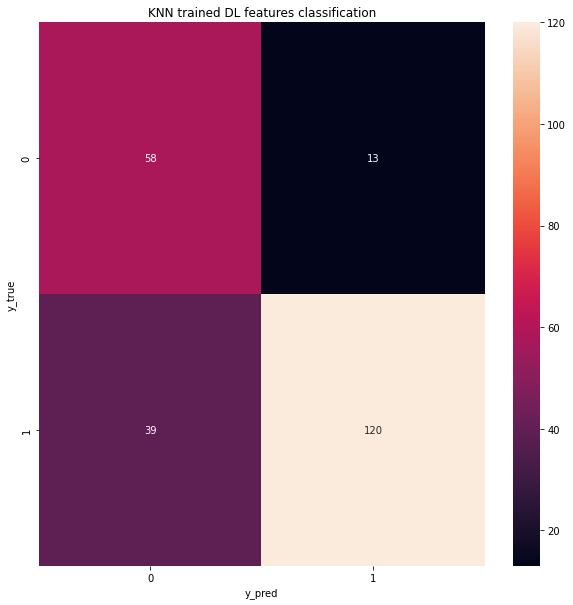

In [41]:
cm_DL = confusion_matrix(y_test, y_test_pred_DL)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_DL,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN trained DL features classification')

print(classification_report(y_test, y_test_pred_DL, target_names=label_names))

# Part 4: DL interpretability

Let's apply some DL interpretability techniques to further understand the DL feature extraction and classification procedure. Let's consider the full DL model architecture

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 123, 92, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 61, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 59, 44, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 29, 22, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 40832)             0         
                                                                 
 dropout_3 (Dropout)         (None, 40832)            

Check dimensions of all convolutional layers in the architecture

In [43]:
for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_6 (3, 3, 3, 32)
conv2d_7 (3, 3, 32, 64)


## Visualize filters weights

Let's visualize the trained weights of the filters in the first convolutional layer

In [44]:
filters, biases = model.layers[0].get_weights()
from matplotlib import pyplot

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

filters.shape
filters1 = filters.squeeze()

In [45]:
filters1.shape

(3, 3, 3, 32)

In the first convolutional layer there are 32 filters, each of size 3x3


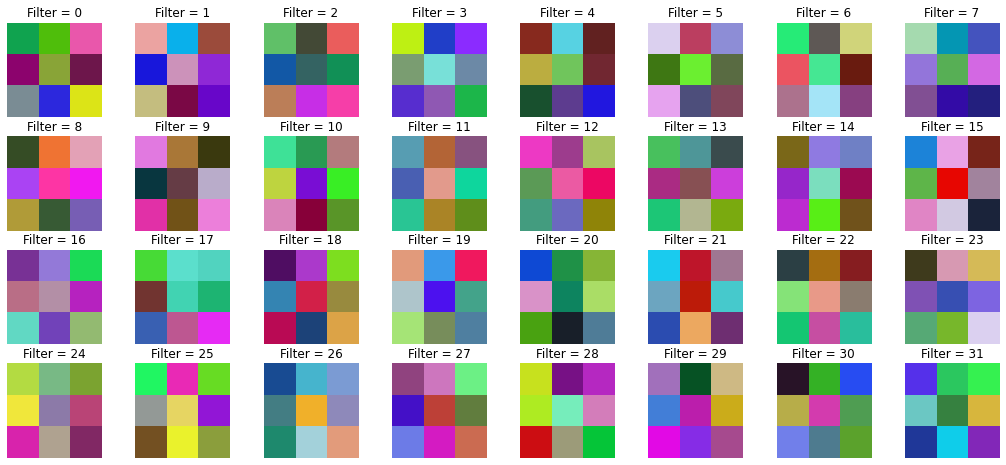

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfilt in range(0,32):
    ax = fig.add_subplot(4, 8, kfilt+1)
    ax.imshow(filters1[:,:,:,kfilt], cmap='gray') 
    ax.set_title('Filter = {}'.format(kfilt))
    ax.axis('off')

## Vizualize the feature maps 

Feature maps are the result of projecting an input image across the different convolutional filters in the convolutional layers of the CNN.

In [47]:
from tensorflow.keras.models import Model

# define a new model with outputs the first layer
model_feat_layer0  = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_feat_layer0.summary()

# extract the features provided by the model of the test input
feat_test_layer0 = model_feat_layer0.predict(x_test1)

print('layer 0 shape {}'.format(feat_test_layer0.shape))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 125, 94, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 123, 92, 32)       896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________
layer 0 shape (230, 123, 92, 32)


plot the feature maps corresponding to the first image in the test subset, which in this case corresponds to a

In [48]:
y_test[0]

1

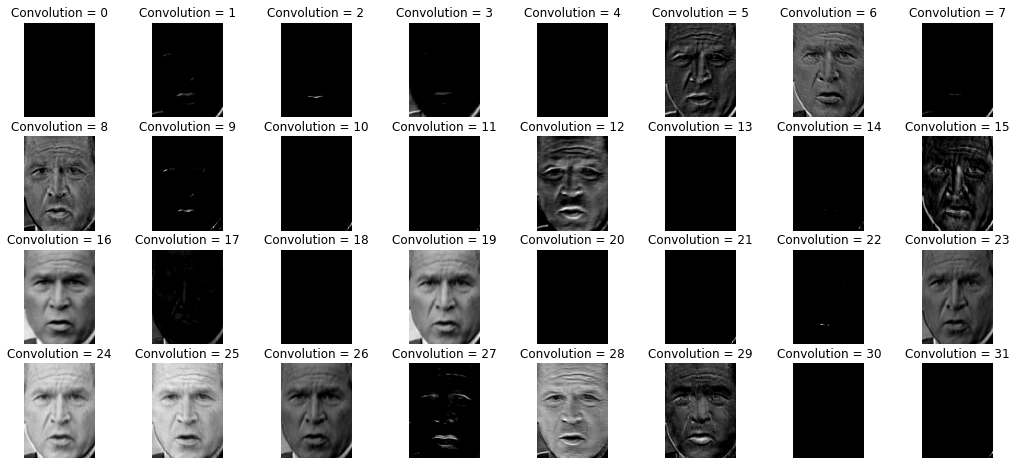

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
for kfeat in range(0,32):
    ax = fig.add_subplot(4, 8, kfeat+1)
    ax.imshow(feat_test_layer0[0,:,:,kfeat], cmap='gray') 
    ax.set_title('Convolution = {}'.format(kfeat))
    ax.axis('off')

## Activation Maximization

https://raghakot.github.io/keras-vis/visualizations/activation_maximization/

Generate an input image that maximizes the filter output activations. i.e., we compute

$\frac{\partial ActivationMaximizationLoss}{\partial input}$ 

and use that estimate to update the input. ActivationMaximization loss simply outputs small values for large filter activations (we are minimizing losses during gradient descent iterations). This allows us to understand what sort of input patterns activate a particular filter. For example, there could be an eye filter that activates for the presence of eye within the input image.

In [50]:
!pip install tf-keras-vis

     |████████████████████████████████| 53 kB 1.2 MB/s 


Change final activation layer from softmax to linear.
To compute the gradients, it is recommended to change the softmax activation function by
a linear function, since with the softmax the maximization of a class can be achieved by
minimising the scores of the other classes, and using a linear function we ensure that the
optimization concentrates only on the class in question.

In [51]:
from tf_keras_vis.activation_maximization import ActivationMaximization
import tensorflow as tf

def model_modifier(current_model):
    current_model.layers[-1].activation = tf.keras.activations.linear
    return current_model

activation_maximization = ActivationMaximization(model,model_modifier,clone=False)

Score function to maximize a certain category

In [52]:
from tf_keras_vis.utils.scores import CategoricalScore

class_score = 1
score = CategoricalScore(class_score)

In [53]:
from tf_keras_vis.activation_maximization.callbacks import PrintLogger as Logger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate maximized activation
activations = activation_maximization(score,callbacks=[Logger(interval=50)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  """


Steps: 050	Scores: [[47.1945686340332]],	Regularization: [('TotalVariation2D', [15.473797798156738]), ('Norm', [35.02497482299805])]
Steps: 100	Scores: [[-4.749974250793457]],	Regularization: [('TotalVariation2D', [8.092872619628906]), ('Norm', [33.54892349243164])]
Steps: 150	Scores: [[4.220005989074707]],	Regularization: [('TotalVariation2D', [5.323523044586182]), ('Norm', [32.58787536621094])]
Steps: 200	Scores: [[6.318892002105713]],	Regularization: [('TotalVariation2D', [4.1148457527160645]), ('Norm', [31.72362518310547])]


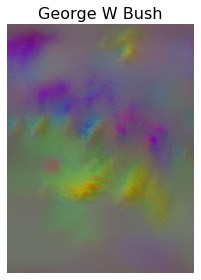

In [54]:
# Visualize 
class_names = label_names

f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations.squeeze())
ax.set_title(class_names[class_score], fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

Let's do the same procedure with all the other faces:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  """


Steps: 050	Scores: [[25.447999954223633]],	Regularization: [('TotalVariation2D', [10.829381942749023]), ('Norm', [34.65695571899414])]
Steps: 100	Scores: [[18.323741912841797]],	Regularization: [('TotalVariation2D', [5.510299205780029]), ('Norm', [33.00099182128906])]
Steps: 150	Scores: [[17.094276428222656]],	Regularization: [('TotalVariation2D', [5.306814670562744]), ('Norm', [31.648605346679688])]
Steps: 200	Scores: [[18.53567886352539]],	Regularization: [('TotalVariation2D', [5.334052085876465]), ('Norm', [30.525768280029297])]
Steps: 050	Scores: [[-1.6640793085098267]],	Regularization: [('TotalVariation2D', [10.633824348449707]), ('Norm', [34.98076248168945])]
Steps: 100	Scores: [[16.902286529541016]],	Regularization: [('TotalVariation2D', [6.784968852996826]), ('Norm', [33.46839141845703])]
Steps: 150	Scores: [[27.783952713012695]],	Regularization: [('TotalVariation2D', [8.005600929260254]), ('Norm', [32.216087341308594])]
Steps: 200	Scores: [[7.950541973114014]],	Regularization:

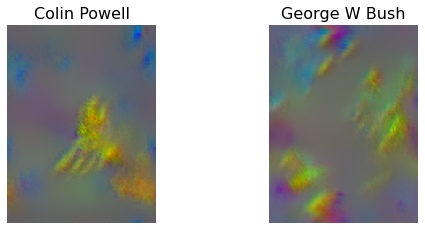

In [55]:
fig = plt.figure(figsize=(18, 8))
for kclass in range(0,n_classes):
    score = CategoricalScore(kclass)
    activation_maximization = ActivationMaximization(model,model_modifier,clone=False)
    activations = activation_maximization(score,callbacks=[Logger(interval=50)])
    ax = fig.add_subplot(2, 4, kclass+1)
    ax.imshow(activations.squeeze())
    ax.set_title(class_names[kclass], fontsize=16)
    ax.axis('off')

## Gradient-based interpretability

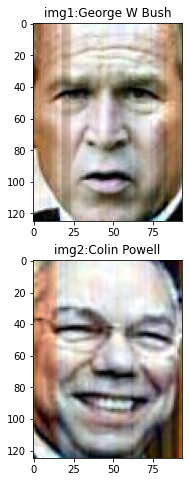

In [58]:
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['George W Bush','Colin Powell']

# Load images and Convert them to a Numpy array
img1 = norm_im(x_test1[0])
img2 = norm_im(x_test1[2])


fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(2, 1, 1)
ax.imshow(img1) 
ax.set_title('img1:'+ image_titles[0])
ax = fig.add_subplot(2, 1, 2)
ax.imshow(img2) 
ax.set_title('img2:'+ image_titles[1])

plt.show()



### GradCam

Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

https://arxiv.org/abs/1610.02391




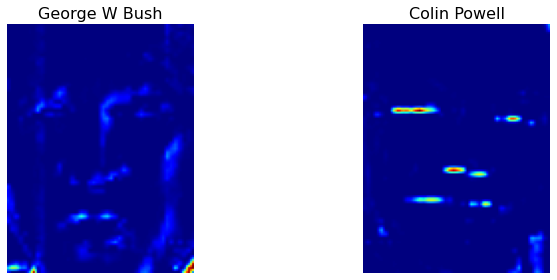

In [59]:
images = np.asarray([np.array(img1), np.array(img2)])
X = images.reshape(2,h,w,3)

score = CategoricalScore([1,0])

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)

# Generate heatmap with GradCAM
cam = gradcam(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=n_classes, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()


### GradCam++

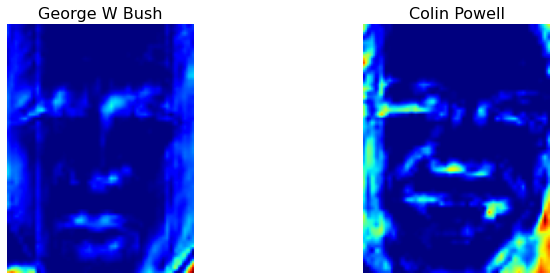

In [60]:
from tf_keras_vis.gradcam import GradcamPlusPlus

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
gradcamplus = GradcamPlusPlus(model,model_modifier,clone=False)

# Generate heatmap with GradCAM
camplus = gradcamplus(score, X, penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=n_classes, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(camplus[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(heatmap, cmap='jet', alpha=1) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

